In [2]:
import keras
from keras import layers
import numpy as np
import pandas as pd

Using TensorFlow backend.


# 数据预处理：

In [3]:
data = pd.read_csv('E:/Python_code/keras_total/日月光华-keras课程资料/航空公司Tweets评论数据/Tweets.csv')

In [4]:
data.head()
# 只用关注两列：airline_sentiment和text —— 态度相当于与标签y，评价文本相当于x
# airline_sentiment	中有3种情绪：中立、积极、消极

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# 数据提取：
data = data[ ['airline_sentiment','text'] ]

In [6]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [7]:
# 查看有哪些评价、每种评价有多少个：
data.airline_sentiment.unique()
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### 提取数据： 

神经网络处理分类问题时，希望不同类别的训练数据具有均匀性（一样多最好）！

这里我们不要“中立的”，并令“negative”和“positive”的数量一样多，都是2363个。

In [8]:
data_p = data[data.airline_sentiment == 'positive']

In [9]:
data_n = data[data.airline_sentiment == 'negative']
data_n = data_n.iloc[:len(data_p)]  # negative数据量和“positive”的一样多！

In [10]:
len(data_n), len(data_p)

(2363, 2363)

### 对原表进行删减与重组：

In [11]:
data = pd.concat([data_n, data_p])

In [12]:
data.head()

,airline_sentiment,text
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
15,negative,@VirginAmerica SFO-PDX schedule is still MIA.
17,negative,@VirginAmerica I flew from NYC to SFO last we...


把数据打散：现在airline_sentiment的分布太扎堆了！

In [13]:
data = data.sample( len(data) )

In [14]:
data.head()

,airline_sentiment,text
1501,negative,@United landed in den on time stuck waiting fo...
11458,positive,@USAirways thanks for reaching out to me. My ...
8546,positive,@JetBlue Hawaii! Get me somewhere warm &amp; I...
2863,negative,@united refreshes my browser right before chec...
12372,positive,"@AmericanAir mission accomplished today, Thank..."


既然现在airline_sentiment列只有“positive”和“negative”这两种，那就把他俩用0和1数值化：

In [15]:
data['review'] = (data.airline_sentiment == 'positive').astype('int')  # 是positive的转为1，是negative转为0

In [16]:
data.head()

,airline_sentiment,text,review
1501,negative,@United landed in den on time stuck waiting fo...,0
11458,positive,@USAirways thanks for reaching out to me. My ...,1
8546,positive,@JetBlue Hawaii! Get me somewhere warm &amp; I...,1
2863,negative,@united refreshes my browser right before chec...,0
12372,positive,"@AmericanAir mission accomplished today, Thank...",1


现在airline_sentiment列的内容已经完全数值化转为review列了，所以airline_sentiment列没有存在必要了！删掉：

In [17]:
del data['airline_sentiment']

In [18]:
data.head()

,text,review
1501,@United landed in den on time stuck waiting fo...,0
11458,@USAirways thanks for reaching out to me. My ...,1
8546,@JetBlue Hawaii! Get me somewhere warm &amp; I...,1
2863,@united refreshes my browser right before chec...,0
12372,"@AmericanAir mission accomplished today, Thank...",1


### 对text的文本进行向量化：文本词嵌入

发现：text中除了必要的字母和常用标点符号外，还有一些无意义的特殊符号，如@；需要先将这些特殊符号删掉：

In [19]:
# 用正则化的方式，保留我们想要的字符，剩下的字符被删掉：
import re

In [20]:
token = re.compile('[A-Za-z]+|[!?,.()]')  # 里面都是我们要保留的字符

In [21]:
# 定义的函数1：把上面定义的正则化规则，适用于所输入的数据；并把大小字母转为小写：
def reg_text(text):
    new_text = token.findall(text)  # 制定的规则处理输入的文本
    new_text = [word.lower() for word in new_text]  # 把大写字母转为小写
    return new_text  # 返回处理后的新文本

In [22]:
data['text'] = data.text.apply(reg_text)  # 应用上面的函数： 

In [23]:
data.head()

,text,review
1501,"[united, landed, in, den, on, time, stuck, wai...",0
11458,"[usairways, thanks, for, reaching, out, to, me...",1
8546,"[jetblue, hawaii, !, get, me, somewhere, warm,...",1
2863,"[united, refreshes, my, browser, right, before...",0
12372,"[americanair, mission, accomplished, today, ,,...",1


现在要对“词+标点符号”进行编号：统计所有text内容中的非重复单词与标点字符

In [47]:
# set数据类型中，虽然没有索引，但是内容不重复！很利于进行总数的统计。
word_set = set()

# 循环统计：
for text in data.text:
    for word in text:
        word_set.add(word) # 如果前后有重复的东西出现，这里不会录入
        
maxword = len(word_set) + 1  # 7100 + 1 

既然用获得单词的向量，那么最简单的方法就是直接把word_set中的单词加上一个索引，让索引来一一对应单词：

In [48]:
word_list = list(word_set)  

In [49]:
word_list.index('spending'), word_list.index(',')

(6110, 3905)

In [50]:
# 把上面的列表，转为“序号与数据对应更好”的字典；
# 列表索引是从0开始的，不太好，我们人为让它索引从1开始：
word_index = dict( (word, word_list.index(word) + 1) for word in word_list )

In [51]:
word_index  # 获得每个单词对应的编号：

{'f': 1,
 'bach': 2,
 'noooooooooooooooooooooope': 3,
 'yywafkfi': 4,
 'seg': 5,
 'facing': 6,
 'include': 7,
 'youretheworst': 8,
 'cookie': 9,
 'maria': 10,
 'customers': 11,
 'manager': 12,
 'avg': 13,
 'atlanta': 14,
 'overflight': 15,
 'passes': 16,
 'rocks': 17,
 'tiredcustomer': 18,
 'aruna': 19,
 'term': 20,
 'painful': 21,
 'self': 22,
 'bank': 23,
 'pqds': 24,
 'esp': 25,
 'blew': 26,
 'noanswer': 27,
 'gluten': 28,
 'court': 29,
 'land': 30,
 'inappropriate': 31,
 'where': 32,
 'resell': 33,
 'intercom': 34,
 'bi': 35,
 'tkvcmhbpim': 36,
 'awww': 37,
 'protected': 38,
 'rage': 39,
 'unfold': 40,
 'wondering': 41,
 'permission': 42,
 'tweeted': 43,
 'onlywaytofly': 44,
 'bloody': 45,
 'play': 46,
 'tamara': 47,
 'flights': 48,
 'mileage': 49,
 'albany': 50,
 'logistics': 51,
 'custserv': 52,
 'pricing': 53,
 'night': 54,
 'nlrphoto': 55,
 'rachelle': 56,
 'thoughts': 57,
 'funds': 58,
 'vieuidf': 59,
 'phone': 60,
 'bet': 61,
 'catering': 62,
 'dollars': 63,
 'sky': 64,
 'uni

In [52]:
# 把评论转换为单词的编号列表/向量：
data_ok = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])

In [53]:
len(data_ok.iloc[123]), len(data_ok.iloc[22])  # 长度不相同

(22, 11)

In [54]:
maxlen = max( len(x) for x in data_ok ) # 40
# 最常的评论长度是40个单词
# 当我们对少于40个单词的句子处理时，需要用'0'这个字符来填充，因此前面的“单词 + 标点字符”总数应该+1 = 7101

把所有的评论填充到40长度（不到40的都用'0'来填充）:

In [55]:
data_ok = keras.preprocessing.sequence.pad_sequences( data_ok.values, maxlen = maxlen )

In [57]:
data_ok[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 1181,  999, 2675, 4021, 5315,
       1315, 6121,  784, 5332, 6443, 5332, 2429, 1727, 6342, 6481, 3138,
       2037, 2364, 5784, 6411, 6079, 7002, 1253])

In [59]:
data_ok.shape  # 2363 * 2 = 4726个样本

(4726, 40)

In [61]:
# 训练数据与对应的标签：
x_train = data_ok
x_lable = data.review.values

# 网络搭建：

In [70]:
model = keras.Sequential()

文本向量化层Embedding：把文本映射为一个密集向量

In [71]:
model.add( layers.Embedding(maxword, 50, input_length=maxlen) )

In [72]:
model.add( layers.LSTM(64) )

In [73]:
model.add( layers.Dense(32, activation = 'relu') )
model.add( layers.Dropout(0.5) )
model.add( layers.Dense(1, activation = 'sigmoid') )  # 二分类 

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 50)            355050    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 386,603
Trainable params: 386,603
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile( optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['acc']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [78]:
history = model.fit(x_train, x_lable, epochs = 5, batch_size = 256, validation_split=0.2)
# validation_split=0.2：把训练数据8-2分开，80%用来训练，20%用来测试 —— 不用预先设定训练、测试数据了！很方便！

Train on 3780 samples, validate on 946 samples
Epoch 1/5
3780/3780 [==============================] - 1s 288us/step - loss: 0.0879 - acc: 0.9725 - val_loss: 0.2136 - val_acc: 0.9218
Epoch 2/5
3780/3780 [==============================] - 1s 294us/step - loss: 0.0630 - acc: 0.9825 - val_loss: 0.2400 - val_acc: 0.9302
Epoch 3/5
3780/3780 [==============================] - 1s 284us/step - loss: 0.0374 - acc: 0.9907 - val_loss: 0.3034 - val_acc: 0.9302
Epoch 4/5
3780/3780 [==============================] - 1s 280us/step - loss: 0.0199 - acc: 0.9947 - val_loss: 0.3441 - val_acc: 0.9218
Epoch 5/5
3780/3780 [==============================] - 1s 276us/step - loss: 0.0172 - acc: 0.9950 - val_loss: 0.3737 - val_acc: 0.9292


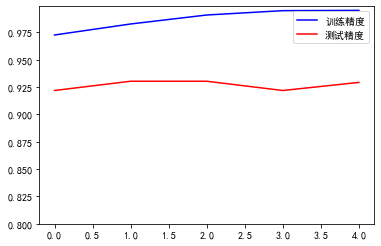

In [79]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 训练精度与测试精度的对比图：
plt.plot( history.epoch, history.history.get('acc'), c = 'b', label = '训练精度' )
plt.plot( history.epoch, history.history.get('val_acc'), c = 'r', label = '测试精度' )
plt.ylim( ymin=0.8 )
plt.legend()